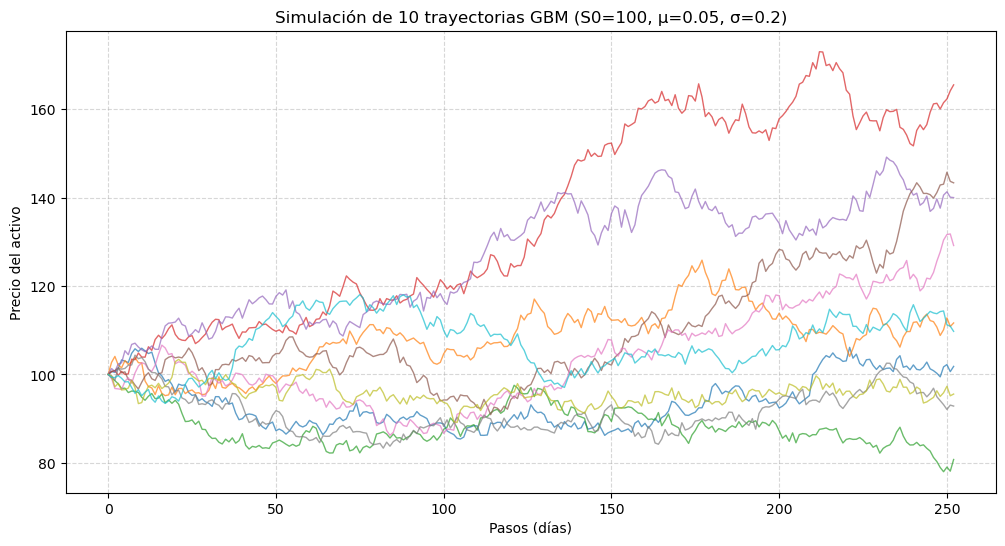

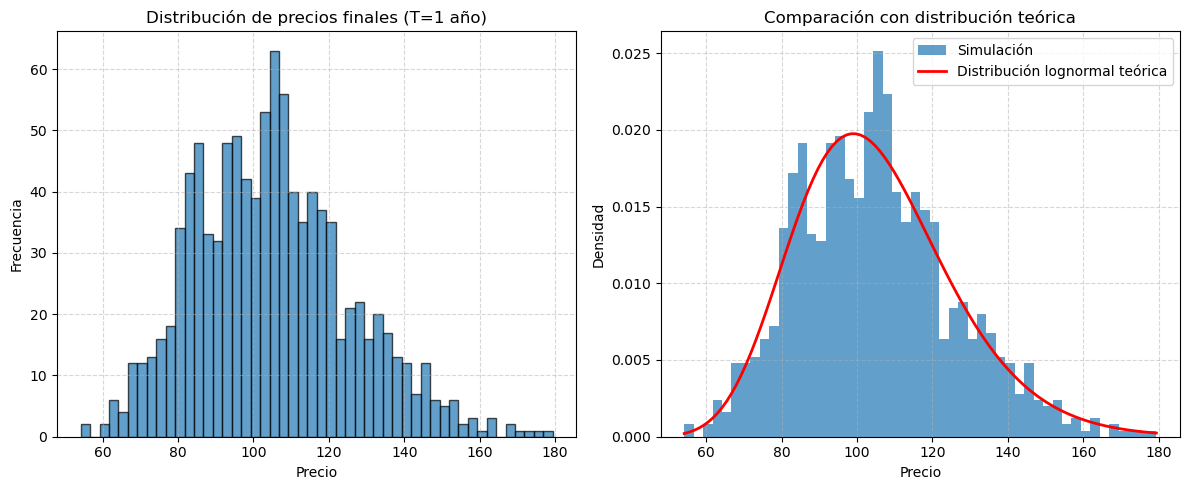


--- ESTADÍSTICOS DE LA SIMULACIÓN (precio final) ---
Media simulada: 104.93
Media teórica (S0 * exp(mu*T)): 105.13
Desviación típica simulada: 20.68
Desviación típica teórica: 21.24

--- VALORACIÓN DE OPCIÓN CALL (K=105) ---
Precio por Monte Carlo (simulado): 7.7443
Precio teórico Black-Scholes: 8.0214
Diferencia: 0.2771

--- INTERPRETACIÓN PARA EL NEGOCIO ---
El Movimiento Browniano Geométrico es el proceso estocástico estándar para modelar precios.
Sus aplicaciones en BBVA Global Markets incluyen:
- Simulación de escenarios de precios para gestión de riesgos (VaR, stress testing).
- Valoración de derivados (opciones, forwards) cuando no hay fórmula cerrada.
- Cálculo de probabilidades de que un activo supere cierto umbral (ej. para estrategias de barrera).
- Generación de trayectorias para backtesting de estrategias de trading.


In [1]:
# ============================================
# PROCESOS ESTOCÁSTICOS EN FINANZAS
# Simulación de Movimiento Browniano Geométrico (GBM)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fijar semilla para reproducibilidad
np.random.seed(42)

# --------------------------------------------
# Parámetros del modelo GBM
# --------------------------------------------
S0 = 100          # Precio inicial del activo (ej. una acción)
mu = 0.05         # Tasa de rendimiento esperada (anual, 5%)
sigma = 0.2       # Volatilidad anual (20%)
T = 1             # Horizonte temporal (1 año)
N = 252           # Número de pasos (días hábiles en un año)
dt = T / N        # Incremento de tiempo (1 día = 1/252 años)

# Número de simulaciones (trayectorias)
M = 10            # Para visualizar claramente, pocas trayectorias
M_muchas = 1000   # Para distribución final, muchas trayectorias

# --------------------------------------------
# Función para simular una trayectoria GBM
# --------------------------------------------
def gbm_trayectoria(S0, mu, sigma, dt, N):
    """
    Simula una trayectoria de precios usando GBM.
    Retorna un array de longitud N+1 con los precios en cada paso.
    """
    # Inicializar array de precios
    precios = np.zeros(N+1)
    precios[0] = S0
    
    # Generar N incrementos de Wiener (normales con media 0, varianza dt)
    dW = np.random.normal(0, np.sqrt(dt), N)
    
    # Iterar para cada paso
    for i in range(1, N+1):
        # Fórmula de GBM en forma discretizada:
        # S(t+dt) = S(t) * exp((mu - 0.5*sigma^2)*dt + sigma * dW)
        precios[i] = precios[i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma * dW[i-1])
    
    return precios

# --------------------------------------------
# Simular y graficar M trayectorias
# --------------------------------------------
plt.figure(figsize=(12,6))

for i in range(M):
    trayectoria = gbm_trayectoria(S0, mu, sigma, dt, N)
    plt.plot(trayectoria, lw=1, alpha=0.7)

plt.title(f'Simulación de {M} trayectorias GBM (S0={S0}, μ={mu}, σ={sigma})')
plt.xlabel('Pasos (días)')
plt.ylabel('Precio del activo')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --------------------------------------------
# Distribución de precios en el tiempo final (T)
# --------------------------------------------
# Simulamos muchas trayectorias para ver la distribución

precios_finales = np.zeros(M_muchas)

for i in range(M_muchas):
    trayectoria = gbm_trayectoria(S0, mu, sigma, dt, N)
    precios_finales[i] = trayectoria[-1]

# Graficar histograma de precios finales
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(precios_finales, bins=50, edgecolor='black', alpha=0.7)
plt.title(f'Distribución de precios finales (T={T} año)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.5)

# También podemos comparar con la distribución teórica lognormal
from scipy.stats import lognorm

# Parámetros de la lognormal teórica
# En GBM, S_T sigue una lognormal con:
# media = ln(S0) + (mu - 0.5*sigma^2)*T
# sigma_log = sigma * sqrt(T)
media_log = np.log(S0) + (mu - 0.5*sigma**2)*T
sigma_log = sigma * np.sqrt(T)

# Valores para la curva teórica
x = np.linspace(min(precios_finales), max(precios_finales), 100)
pdf_teorica = lognorm.pdf(x, s=sigma_log, scale=np.exp(media_log))

# Normalizar para que coincida con el histograma
# (escala para que el área sea 1, mientras que el histograma tiene frecuencias absolutas)
# Para comparar, normalizamos el histograma a densidad
plt.subplot(1,2,2)
plt.hist(precios_finales, bins=50, density=True, alpha=0.7, label='Simulación')
plt.plot(x, pdf_teorica, 'r-', lw=2, label='Distribución lognormal teórica')
plt.title('Comparación con distribución teórica')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# --------------------------------------------
# Estadísticos de la simulación vs teoría
# --------------------------------------------
print("\n--- ESTADÍSTICOS DE LA SIMULACIÓN (precio final) ---")
print(f"Media simulada: {np.mean(precios_finales):.2f}")
print(f"Media teórica (S0 * exp(mu*T)): {S0 * np.exp(mu*T):.2f}")
print(f"Desviación típica simulada: {np.std(precios_finales):.2f}")
print(f"Desviación típica teórica: {S0 * np.exp(mu*T) * np.sqrt(np.exp(sigma**2*T)-1):.2f}")

# --------------------------------------------
# Aplicación: Valoración de una opción europea (call) por Monte Carlo
# --------------------------------------------
# Supongamos una opción call con strike K = 105, vencimiento T=1 año

K = 105
# Pago de la opción al vencimiento: max(S_T - K, 0)
payoffs = np.maximum(precios_finales - K, 0)

# Descontamos a valor presente (tasa libre de riesgo, aquí usamos mu como aproximación,
# aunque en realidad debería ser la tasa libre de riesgo r, pero mantenemos mu por simplicidad)
r = mu  # asumimos que la tasa libre de riesgo es igual a la deriva (solo para este ejemplo)
precio_opcion_simulado = np.exp(-r*T) * np.mean(payoffs)

# Precio teórico Black-Scholes (aproximado, con los mismos parámetros)
from scipy.stats import norm

def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    return call

precio_bs = black_scholes_call(S0, K, T, r, sigma)

print("\n--- VALORACIÓN DE OPCIÓN CALL (K=105) ---")
print(f"Precio por Monte Carlo (simulado): {precio_opcion_simulado:.4f}")
print(f"Precio teórico Black-Scholes: {precio_bs:.4f}")
print(f"Diferencia: {abs(precio_opcion_simulado - precio_bs):.4f}")

# --------------------------------------------
# Interpretación de negocio
# --------------------------------------------
print("\n--- INTERPRETACIÓN PARA EL NEGOCIO ---")
print("El Movimiento Browniano Geométrico es el proceso estocástico estándar para modelar precios.")
print("Sus aplicaciones en BBVA Global Markets incluyen:")
print("- Simulación de escenarios de precios para gestión de riesgos (VaR, stress testing).")
print("- Valoración de derivados (opciones, forwards) cuando no hay fórmula cerrada.")
print("- Cálculo de probabilidades de que un activo supere cierto umbral (ej. para estrategias de barrera).")
print("- Generación de trayectorias para backtesting de estrategias de trading.")
